In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, roc_auc_score
import pickle
import sys
import os

from sklearn.linear_model import ElasticNet

from scipy import stats
from collections import OrderedDict
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from bayes_opt import BayesianOptimization
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
import gc
from sklearn.preprocessing import StandardScaler

#from xgboost import XGBRegressor

In [2]:
space_LM = [Real(0, 1, "uniform", name='alpha'),
           Real(0, 1, "uniform", name='l1_ratio')]

space_XGB = [Integer(1, 10, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Real(10**0, 10**1, "uniform", name="gamma")]

space_NN = [Real(low=1e-4, high=1e-2, prior='log-uniform', name='learning_rate'),
              Integer(low=1, high=3, name='num_dense_layers'),
              Integer(low=1, high=10, prior='uniform', name='num_input_nodes'),
              Integer(low=1, high=10, name='num_dense_nodes'),
              Categorical(categories=['relu', 'tanh'], name='activation')]

In [3]:
def optimize_enet(x,y):

    @use_named_args(space_LM)
    def objective(**params):
        reg=ElasticNet(max_iter=1000, normalize=False)
        reg.set_params(**params)
        cval = cross_val_score(reg, x, y, scoring='r2', cv=3)
        cval[np.where(cval < 0)[0]] = 0

        return -cval.mean()

    res_gp = gp_minimize(objective, space_LM, n_calls=20, random_state=0)
    return res_gp


In [4]:
def enet_train(alpha,l1_ratio,x,y):
    clf=ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=1000,normalize=False)
    #clf.fit(x,y)
    
    cval = cross_val_score(clf, x, y, scoring='r2', cv=3)
    cval[np.where(cval < 0)[0]] = 0
    return cval.mean()
    
    return clf.score(x, y)
def optimize_enet_bayesopt(x,y):
    """Apply Bayesian Optimization to select enet parameters."""
    def function(alpha, l1_ratio):
          
        return enet_train(alpha=alpha, l1_ratio=l1_ratio, x=x, y=y)
    
    optimizer = BayesianOptimization(
        f=function,
        pbounds={"alpha": (1e-6, 0.99), "l1_ratio": (1e-6,0.99)},
        random_state=0,
        verbose=1,
    )
    optimizer.probe(
    params=[1e-3, 1e-3],
    lazy=True,
    )
    optimizer.maximize(n_iter=25, init_points=20, acq="ei", xi=1e-1)

    
    #train enet
    
    return optimizer.max

In [5]:
#### read a real data stream file 
PATH_dat ="C:\\Users\Pilin\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\derivatives\Int_old_grid\sub_003_sess_right_run_4.p"
#"C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\derivatives\\Int_old_grid\\sub_003_sess_right_run_4.p"

In [6]:
raw_ = np.load(PATH_dat, allow_pickle=True)

In [7]:
raw_.keys()

dict_keys(['vhdr_file', 'resamplingrate', 'BIDS_path', 'projection_grid', 'bv_raw', 'ch_names', 'data_', 'subject', 'run', 'sess', 'sess_right', 'used_channels', 'coord_patient', 'proj_matrix_run', 'fs', 'line_noise', 'seglengths', 'normalization_samples', 'new_num_data_points', 'downsample_idx', 'filter_fun', 'offset_start', 'arr_act_grid_points', 'rf_data_median', 'pf_data_median', 'raw_label_baseline', 'label_baseline_corrected', 'label_baseline_corrected_onoff', 'label', 'label_con_true'])

In [8]:
def append_time_dim(arr, y_, time_stamps):
    """
    apply added time dimension for the data array and label given time_stamps (with downsample_rate=100) in 100ms / need to check with 1375Hz
    """
    time_arr = np.zeros([arr.shape[0]-time_stamps, int(time_stamps*arr.shape[1])])
    for time_idx, time_ in enumerate(np.arange(time_stamps, arr.shape[0])):
        for time_point in range(time_stamps):
            time_arr[time_idx, time_point*arr.shape[1]:(time_point+1)*arr.shape[1]] = arr[time_-time_point,:]
    return time_arr, y_[time_stamps:]

In [9]:
raw_["ch_names"]

['STN_RIGHT_0',
 'STN_RIGHT_1',
 'STN_RIGHT_2',
 'ECOG_RIGHT_0',
 'ECOG_RIGHT_1',
 'ECOG_RIGHT_2',
 'ECOG_RIGHT_3',
 'ECOG_RIGHT_4',
 'ECOG_RIGHT_5',
 'ECOG_RIGHT_6',
 'ECOG_RIGHT_7',
 'MOV_RIGHT',
 'MOV_LEFT']

In [10]:
X = raw_["rf_data_median"][:,0,:] # ch 0 STN_RIGHT_0
y = raw_["label_baseline_corrected"][0,:]

In [11]:
X_, y_ = append_time_dim(X, y, time_stamps=5)

In [12]:
optimizer=optimize_enet(x=X_,y=y_)

C:\Users\Pilin\Anaconda3\envs\base (root)\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.135183535179679, tolerance: 0.0014794045058607024
  positive)
C:\Users\Pilin\Anaconda3\envs\base (root)\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.472250847507858, tolerance: 0.001744806472822137
  positive)
C:\Users\Pilin\Anaconda3\envs\base (root)\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.127917521893236, tolerance: 0.00251898559993813
  positive)
C:\Users\Pilin\Anaconda3\envs\base (root)\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated a

In [13]:
optimizer.fun

-0.013070825225774296

In [14]:
optimizer["x"]

[1.0, 0.0]

In [15]:
model=ElasticNet(alpha=optimizer.x[0], l1_ratio=optimizer.x[1], max_iter=1000)
model.fit(X_, y_)


C:\Users\Pilin\Anaconda3\envs\base (root)\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.945504692626994, tolerance: 0.0028762885734443756
  positive)


ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.0,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [16]:
# get coef and plot them
coef=model.coef_

C:\Users\Pilin\Anaconda3\envs\base (root)\lib\site-packages\ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


<StemContainer object of 3 artists>

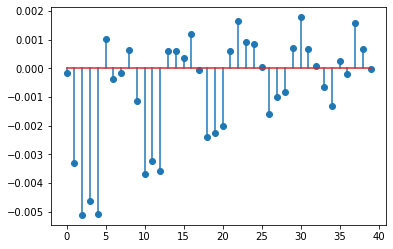

In [17]:
plt.stem(coef) #all coef are selected. No regularization is being made. 

### try now with the other library

In [18]:
optimizer2=optimize_enet_bayesopt(x=X_,y=y_)

|   iter    |  target   |   alpha   | l1_ratio  |
-------------------------------------------------
|  9        |  0.01397  |  0.07033  |  0.08626  |
|  22       |  0.01877  |  0.009052 |  0.2546   |


In [19]:
optimizer2['params'] #here we see they are different from "no-regularization"

{'alpha': 0.00905212096699435, 'l1_ratio': 0.25464399924891473}

C:\Users\Pilin\Anaconda3\envs\base (root)\lib\site-packages\ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """


<StemContainer object of 3 artists>

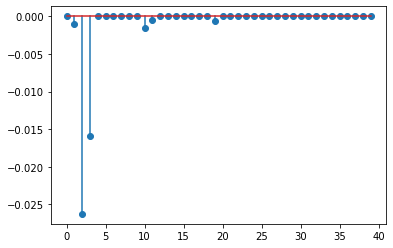

In [20]:
model2=ElasticNet(alpha=optimizer2['params']['alpha'], l1_ratio=optimizer2['params']['l1_ratio'], max_iter=1000, normalize=False)
model2.fit(X_, y_)
#get coef
coef2=model2.coef_
plt.stem(coef2) #most of the coef are zero.

In [21]:
#does it change prediction?
model.score(X_, y_)


0.03951294489641699

In [22]:
model2.score(X_, y_) #well in this example improves performance, but it is in training. but about in new unseen data?


0.04302614732610377

In [23]:
PATH_dat ="C:\\Users\Pilin\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\derivatives\Int_old_grid\sub_003_sess_right_run_5.p"
raw_ = np.load(PATH_dat, allow_pickle=True)
Xte = raw_["rf_data_median"][:,0,:] # ch 0 STN_RIGHT_0
yte = raw_["label_baseline_corrected"][0,:]
Xte_, yte_ = append_time_dim(Xte, yte, time_stamps=5)

In [24]:
model.score(Xte_, yte_) 


0.0354529266083361

In [25]:
model2.score(Xte_, yte_) #here we see, the score in testing does not change very much 
#in fact, it may decrese (it is overfited, most probably for small training data) 
#but we have a more interpretable model by making feature selection. We see by the two stem plots that the
#most relevant features are in the first ones. 

0.031021718599221315